# Unsupervised learning model for Columbia River Basalt data

In [1]:
#this is jupyter notebook version GMM on GRB v2.py

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_gaussian_quantiles
from sklearn import linear_model, datasets
from scipy.cluster import hierarchy
from sklearn.metrics import silhouette_samples, silhouette_score, homogeneity_completeness_v_measure
#from scipy.cluster.hierarchy import dendrogram
import matplotlib.cm as cm
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
#from pandas.plotting import scatter_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
import statistics as st
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.cluster import v_measure_score
from scipy import stats
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import NMF
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from scipy.signal import find_peaks

from scipy import mean

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from importlib import reload
import math

from sklearn.utils import resample
from sklearn.mixture import GaussianMixture

import itertools

from scipy import linalg
import matplotlib as mpl

from sklearn import mixture


In [4]:

!pwd

/Users/leif/gitrepos/learngeochem/notebooks/Hampton_CRB


In [5]:
############# CRB DATAFRAME UPDATED
#url='https://drive.google.com/file/d/1KX2-be5wG2gkf_l_5UvuBhCpA4rtRrys/view?usp=sharing'
#path='https://drive.google.com/uc?export=download&id='+ url.split('/')[-2]
#path = '/gpfs/home/leif/Desktop/CRB_ML/CRB_dataframe_completed_update 2022.csv'
path = '/Users/leif/gitrepos/learngeochem/notebooks/Hampton_CRB/CRB_dataframe_completed_update 2022.csv'

data=pd.read_csv(path, header=0)

print(data.shape)
# data = data_.dropna(axis=0, how='any')

features_ = data.drop(columns=['FeO*', 'FeO', 'Fe2O3','Ga', 'Zn', 'Pb', 'La', 'Ce', 'Th', 'U', 'Formation', 'Member','Source', 'Polarity'])
features_ = features_.dropna(axis=0, how='any')
# drop rows with zeros 
features_ = features_[~(features_ == 0).any(axis=1)]

#MemberID = 48 is "undifferentiated CRB", no Member labels...
features_.drop(features_.index[features_['MemberID'] == 48], inplace=True)

#define here whether to classify based on formation or member
#labels= features_.loc[:,'MemberID']
labels= features_.loc[:,'FormationID']
labelz= features_.loc[:,'MemberID']

df_CRB = features_.drop(columns=['MemberID','FormationID'])
#features_ = features_.drop(columns=['MemberID','FormationID'])

print(df_CRB.shape)
df_CRB.head(3)

(9446, 36)
(5430, 20)


,SiO2,TiO2,Al2O3,MnO,MgO,CaO,Na2O,K2O,P2O5,Ni,Cr,Sc,V,Ba,Rb,Sr,Zr,Y,Nb,Cu
266,47.08,1.786,15.58,0.173,8.50,10.00,2.68,0.44,0.252,199.4,185.3,27.2,274.0,164.4,3.4,487.1,118.5,23.0,10.2,69.9
267,46.94,1.866,15.41,0.170,8.23,9.92,2.70,0.46,0.269,205.1,185.8,27.4,264.1,153.5,6.8,484.9,127.1,24.8,10.5,83.7
271,48.64,2.274,16.17,0.238,5.17,9.14,3.16,0.94,0.368,134.6,127.2,27.3,257.1,121.1,4.4,469.6,138.3,26.0,9.8,42.9


In [6]:
def makeratios(DF):
    cc = list(combinations(DF.columns,2))
    cnames=[]
    for c in cc:
        cname=c[1] + '/' + c[0]
        cnames.append(cname)
    
    ratios = pd.concat([DF[c[1]].divide(DF[c[0]]) for c in cc], axis=1, keys=cnames)
    #now append the ratios onto the original dataframe
    df_wratios = pd.concat([DF,ratios],axis=1)
    
    return df_wratios    

In [7]:

#df1.replace([np.inf, -np.inf], np.nan, inplace=True)
#df1.dropna(axis=1) 


#check that we don't have any negative or zero elements
print((df_CRB.values <= 0).any())
print( (df_CRB == 0).sum().sum())

#extract just Grande Ronde
df_gr= features_.loc[(features_['FormationID'] == 3)] #Grande Ronde

df_gr_labels=df_gr.loc[:,'MemberID']

labels_gr= features_.loc[:,'FormationID']

df_gr = df_gr.drop(columns=['MemberID','FormationID'])

print(df_gr.shape)

#extract Imnaha
df_im= features_.loc[(features_['FormationID'] == 2)] #Imnaha
df_im_labels=df_im.loc[:,'MemberID']
df_im = df_im.drop(columns=['MemberID','FormationID'])

mean_im = df_im.mean()

# print(mean_im)
# features_PTim= PowerTransformer(method="box-cox").fit_transform(mean_im)
# mean_im =pd.DataFrame(features_PTim, columns=mean_im.columns)

# mean_im = mean_im.T


#features.reset_index()
#features_4group = pd.concat([features,labels], axis=1)
#features_4group = features_4group.dropna(axis=0, how='any')
#features = pd.DataFrame(features_4group)

#new_df = new_df.drop(columns=['MemberID','FormationID'])


False
0
(3259, 20)


0
(2888, 20)
(2888, 210)
Making ratios: 210 new features from 20 initial features
Number of samples is 2888
(2888, 20)


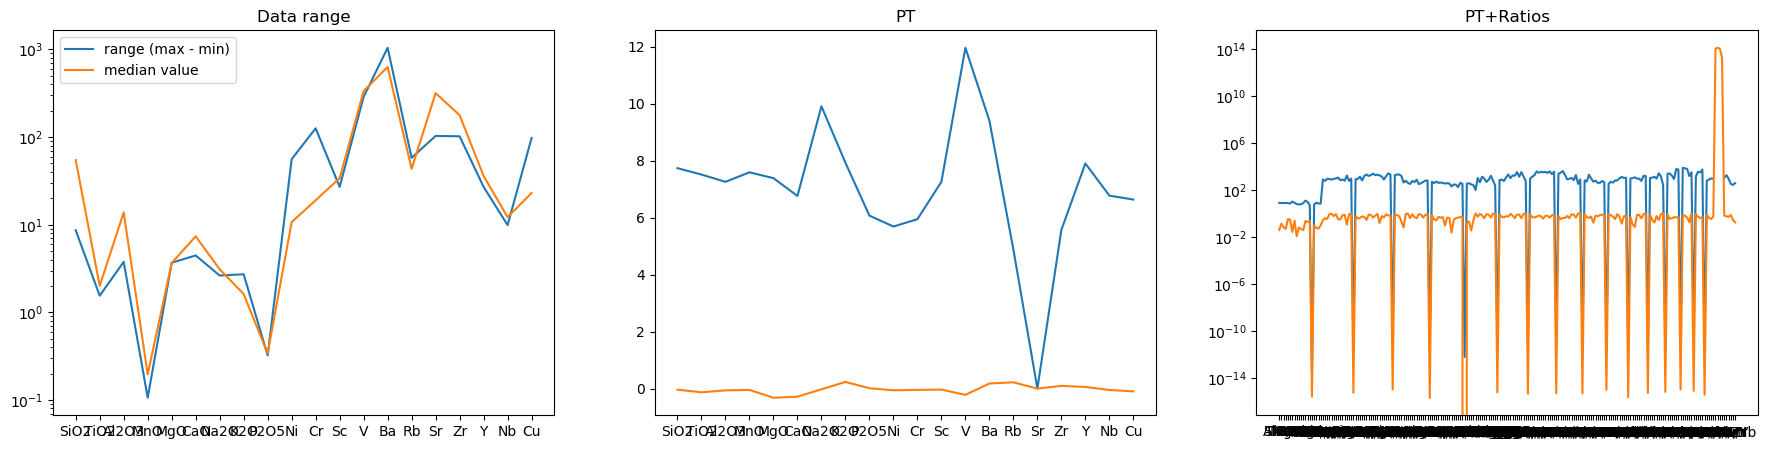

In [8]:
#order of optional preprocessing is important! Three steps: Remove outliers, make ratios, Power transform (vary order?)

#SPECIFY HERE WHICH SUBSET OF DATA (ALL CRB OR GR) IS USED

df = df_gr#df_CRB #df_gr
labels_df = df_gr_labels#labelz #labelz is member level

#Remove outliers
#dropping rows that are greater than 3 standard deviations away from mean ..?
z_scores = stats.zscore(df) #calculate z-scores of `df`

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df = df[filtered_entries]
labels_df = labels_df[filtered_entries]

#df.plot(subplots=True, layout=(4,5),kind='box',figsize=[14,8])
#df.min(axis=1).hist()

fig, axs = plt.subplots(1,3,figsize=[22,5])
#fig.suptitle('Vertically stacked subplots')

axs[0].set_title('Data range')
axs[0].plot(df.max()-df.min(),label='range (max - min)')
axs[0].plot(df.median(),label='median value')
#axs[0].plot(df.min(),label='min')

axs[0].legend()
axs[0].set_yscale('log')
#df.plot('SiO2','TiO2',kind='scatter')
#df.max(axis=1).hist()
#print(df.head(3))

##############################
#Power Transform 

#features = features[~(features==0).all(axis=1)]
print( (df == 0).sum().sum())

#power transform for geochemical data: https://link.springer.com/article/10.1007/BF01043245
df_PT= PowerTransformer(method="box-cox").fit_transform(df)
df_PT =pd.DataFrame(df_PT, columns=df.columns)#

print(df_PT.shape)
axs[1].set_title('PT')
axs[1].plot(df_PT.max()-df_PT.min())
axs[1].plot(df_PT.median())
#axs[1].set_yscale('log')
#axs[1].plot(df_PT.min())

#df_PT.plot(subplots=True, layout=(4,5),kind='box',figsize=[14,8])
#df_PT.min(axis=1).hist()

##############################
#Make ratios of every column with every other column
df_ratios = pd.DataFrame(makeratios(df_PT))

print(df_ratios.shape)
df_ratios = df_ratios.dropna(axis=0, how='any')

print("Making ratios: " + str(df_ratios.shape[1]) + " new features from " + str(df.shape[1]) + " initial features")

axs[2].set_title('PT+Ratios')
axs[2].plot(df_ratios.max()-df_ratios.min())
axs[2].plot(abs(df_ratios.median()))
#axs[1].plot(df_ratios.min())
axs[2].set_yscale('log')




#final updated data frame with preprocessing

#df_new =pd.DataFrame(features_PT, columns=features.columns)
df = pd.DataFrame(df_PT, columns=df_PT.columns)

print("Number of samples is " + str(df.shape[0]))


#df = df.dropna(axis=0, how='any')
# drop rows with zeros 
#df = df[~(features_ == 0).any(axis=1)]
print(df.shape)

#fig.savefig('Preprocess_opt2.png')
#print(df.shape)
#df.head()

In [9]:


############# MORB Average Composition
url_morb='https://drive.google.com/file/d/1MOBiBdPEy0GbzQb_EkuyOIFc2Bg4cosa/view?usp=sharing'
path_morb='https://drive.google.com/uc?export=download&id='+ url_morb.split('/')[-2]
morb_data=pd.read_csv(path_morb, header=0)

#features_PTm= PowerTransformer(method="box-cox").fit_transform(morb_data)
#morb_data =pd.DataFrame(features_PTm, columns=morb_data.columns)


############# Partial Melt Composition Petcovic
url_pm='https://drive.google.com/file/d/1yVJ27hqtC5RSZpw9vpp940qfumCBnCZE/view?usp=sharing'
path_pm='https://drive.google.com/uc?export=download&id='+ url_pm.split('/')[-2]
pm_data=pd.read_csv(path_pm, header=0)

#features_PTpm= PowerTransformer(method="box-cox").fit_transform(pm_data)
#pm_data =pd.DataFrame(features_PTpm, columns=pm_data.columns)


#new_df2 = new_df.div(morb_data.iloc[0], axis='columns')


/var/folders/sc/l94184295fdfnlyrwdthmhwc0000gq/T/ipykernel_87303/1193806344.py:63: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(meanz, v[0], v[1], 180.0 + angle, color=color)


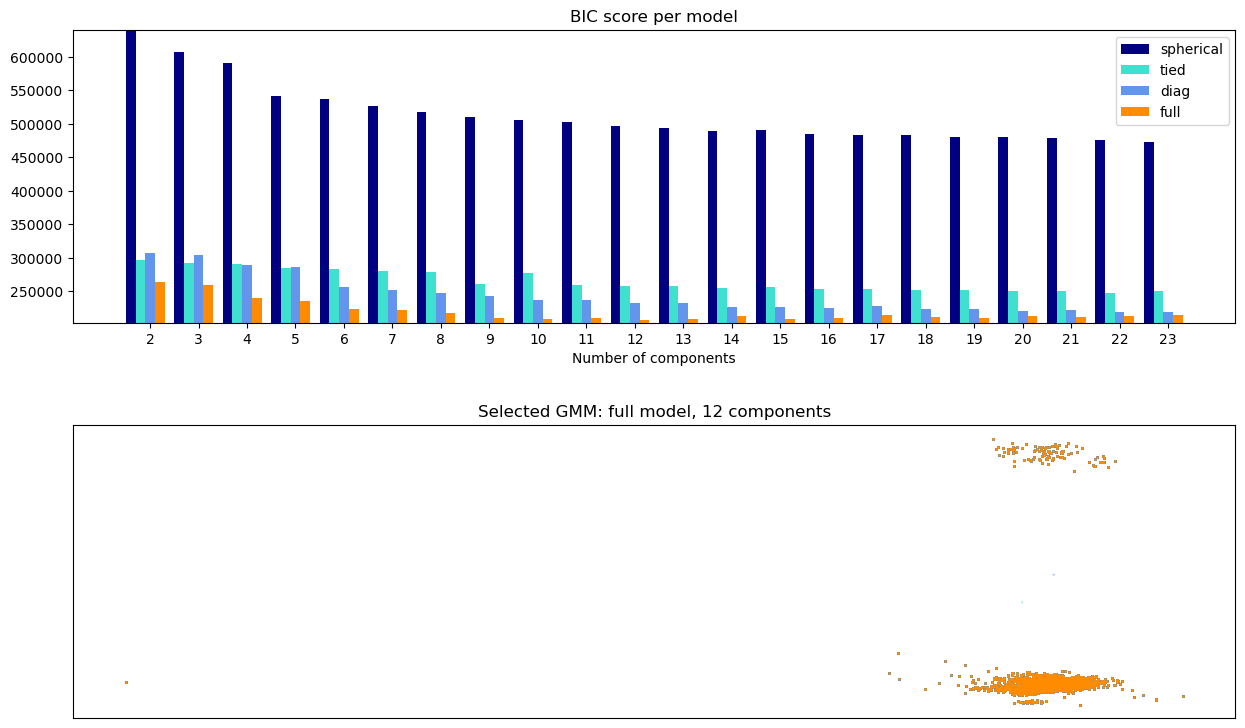

In [10]:
###### Calculate BIC

lowest_bic = np.infty
bic = []
n_components_range = range(2, 24)
cv_types = ["spherical", "tied", "diag", "full"]

for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(df_gr)
        bic.append(gmm.bic(df_gr))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(15, 8))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
#plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(df_gr)
for i, (meanz, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(df_gr.iloc[:,0], df_gr.iloc[:,1], 0.8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(meanz, v[0], v[1], 180.0 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)
plt.subplots_adjust(hspace=0.35, bottom=0.02)
plt.show()



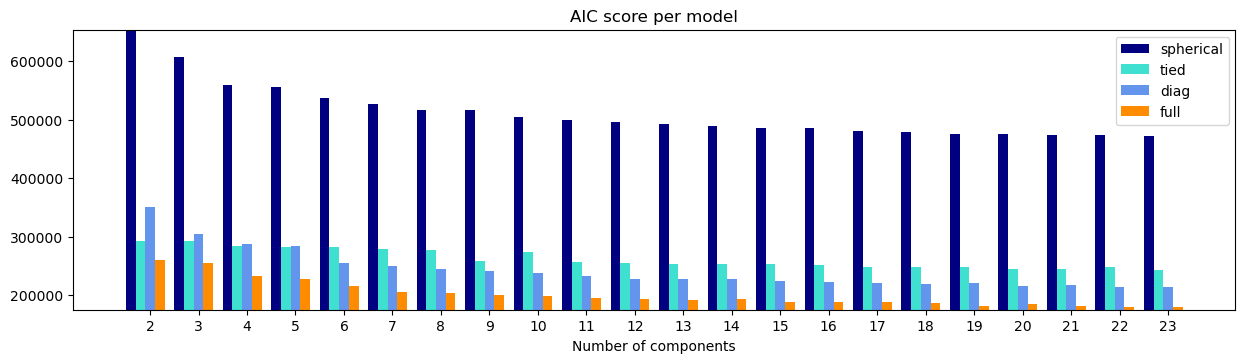

In [11]:

######### Calculate AIC
lowest_aic = np.infty
aic = []
n_components_range = range(2,24)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm2 = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm2.fit(df_gr)
        aic.append(gmm2.aic(df_gr))
        if aic[-1] < lowest_aic:
            lowest_aic = aic[-1]
            best_gmm_aic = gmm2

aic = np.array(aic)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
clf2 = best_gmm_aic
bars2 = []

# Plot the AIC scores
plt.figure(figsize=(15, 8))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos2 = np.array(n_components_range) + 0.2 * (i - 2)
    bars2.append(
        plt.bar(
            xpos2,
            aic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([aic.min() * 1.01 - 0.01 * aic.max(), aic.max()])
plt.title("AIC score per model")
xpos2 = (
    np.mod(aic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(aic.argmin() / len(n_components_range))
)
#plt.text(xpos2, aic.min() * 0.97 + 0.03 * aic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)

/var/folders/sc/l94184295fdfnlyrwdthmhwc0000gq/T/ipykernel_87303/1135643606.py:14: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(meand, v[0], v[1], 180.0 + angle, color=color)


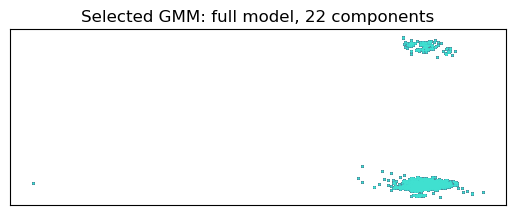

In [12]:

# Plot the winner
splot2 = plt.subplot(2, 1, 2)
Y_ = clf2.predict(df_gr)
for i, (meand, cov, color) in enumerate(zip(clf2.means_, clf2.covariances_, color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(df_gr.iloc[:,0], df_gr.iloc[:,1], 0.8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(meand, v[0], v[1], 180.0 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title(
    f"Selected GMM: {best_gmm_aic.covariance_type} model, "
    f"{best_gmm_aic.n_components} components"
)
plt.subplots_adjust(hspace=0.35, bottom=0.02)
plt.show()

In [13]:
#### USE AIC AND BIC TO FIND APPROPRIATE NUMBER OF CLUSTERS

# Set up a range of cluster numbers to try
n_range = range(2,24)

# Create empty lists to store the BIC and AIC values
bic_score = []
aic_score = []

# Loop through the range and fit a model
for n in n_range:
    gm = GaussianMixture(n_components=n, covariance_type="full",
                         random_state=123, 
                         n_init=50)
    gm.fit(new_df)
    #gm.fit(df_new)
    
    # Append the BIC and AIC to the respective lists
    bic_score.append(gm.bic(new_df))
    aic_score.append(gm.aic(new_df))
    
# Plot the BIC and AIC values together
fig, ax = plt.subplots(figsize=(12,5),nrows=1, dpi=300)
ax.plot(n_range, bic_score, '-o', color='orange', label='BIC')
ax.plot(n_range, aic_score, '-o', color='green', label='AIC')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.set_title('BIC and AIC Scores Per Number Of Clusters')
ax.legend()



NameError: name 'new_df' is not defined

In [9]:
print(len(df_new),len(df_gr_labels))

3259 3259


In [14]:

data_to_use=df#new_df#df_new
labels_to_use=labels_df#new_labels#df_gr_labels#labels

n_cluster = 3#48
#formations = ['Picture Gorge',' Steens', 'Imnaha', 'Grande Ronde', 'Wanapum', 'Saddle Mountains']

###### Using Best Number of Clusters from Above
random_states=10

## Cluster Original Data
HCV_kmeans_orig=[]
HCV_spec_orig=[]
HCV_agg_orig=[]
HCV_mlr_orig=[]

    
        ###Cluster each data set
SS_kmeans=[]
HCV_kmeans=[]


max_hcv=[]
        
for q in range(random_states):
    y_pred = GaussianMixture(n_components=n_cluster, covariance_type="full", random_state=q, n_init=10).fit_predict(data_to_use)
#    y_pred = KMeans(n_clusters=3, random_state=q).fit_predict(df1)
 #   y_pred = SpectralClustering(n_clusters=2, random_state=q, affinity='nearest_neighbors', eigen_solver='arpack', assign_labels='kmeans').fit_predict(df2)
#    y_pred_agg = AgglomerativeClustering(n_clusters=3).fit_predict(X1)

#    Metrics for Clustering on W matrix after decomposition
#            silhouette_avg = silhouette_score(df1, y_pred)
#    print(silhouette_avg)
    hcv=v_measure_score(labels_to_use ,y_pred)
#    print(hcv)
#            SS_kmeans.append(silhouette_avg)
            
    HCV_kmeans.append(hcv)
    silhouette_avg = silhouette_score(data_to_use, y_pred)
    SS_kmeans.append(silhouette_avg)
    
max_HCV = max(HCV_kmeans)  # Find the maximum y value
#        max_RS = range(random_states)[HCV_kmeans.argmax()]  # Find the x value corresponding to the maximum y value
#        print (max_HCV, max_RS)
#max_hcv.append(max_HCV)
print(max_HCV)

max_SScore = max(SS_kmeans)
print(max_SScore)

#minerror = min(Errors2)
max_HCV_pos = HCV_kmeans.index(max_HCV)
hcvmax = range(random_states)[max_HCV_pos]




0.3472289768629224
0.1601837516735034


In [8]:
max(df[df == np.inf].count())

0

/Users/leif/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/leif/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


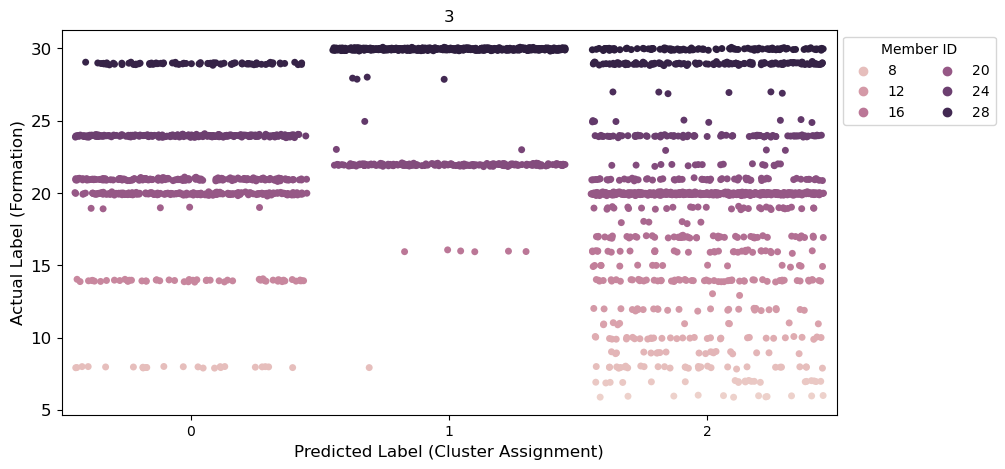

In [15]:

#### Best Fit Number of Clusters and Best Covariance

y_pred_G = GaussianMixture(n_components=n_cluster, covariance_type="full", random_state=hcvmax, n_init=10)
y_pred_g= y_pred_G.fit_predict(data_to_use)


noise = np.random.normal(-.05,.05,len(data_to_use))
plt.figure(figsize=(10,5))
#sns.stripplot(x=y_pred_g, y=labels+noise, jitter=.45)
sns.stripplot(x=y_pred_g, y=labels_to_use+noise, hue=labels_to_use, jitter=.45)
plt.ylabel('Actual Label (Formation)', fontsize=12);
plt.xlabel('Predicted Label (Cluster Assignment)', fontsize=12);
plt.title(n_cluster, fontsize=12)
sns.color_palette()
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.legend(title='Member ID', bbox_to_anchor=(1, 1), ncol=2)

#plt.savefig('GRB_unsup_opt1.png')


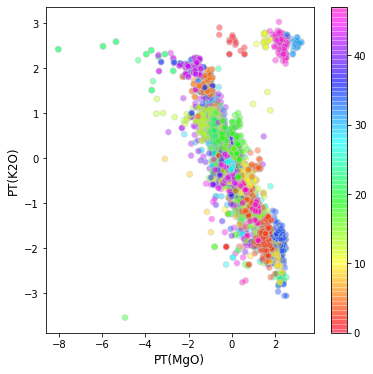

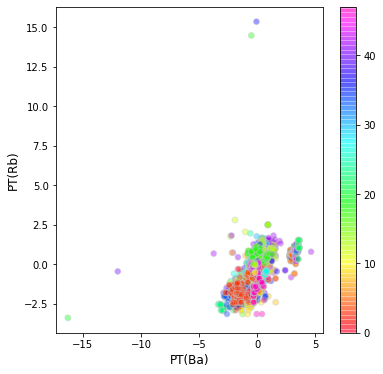

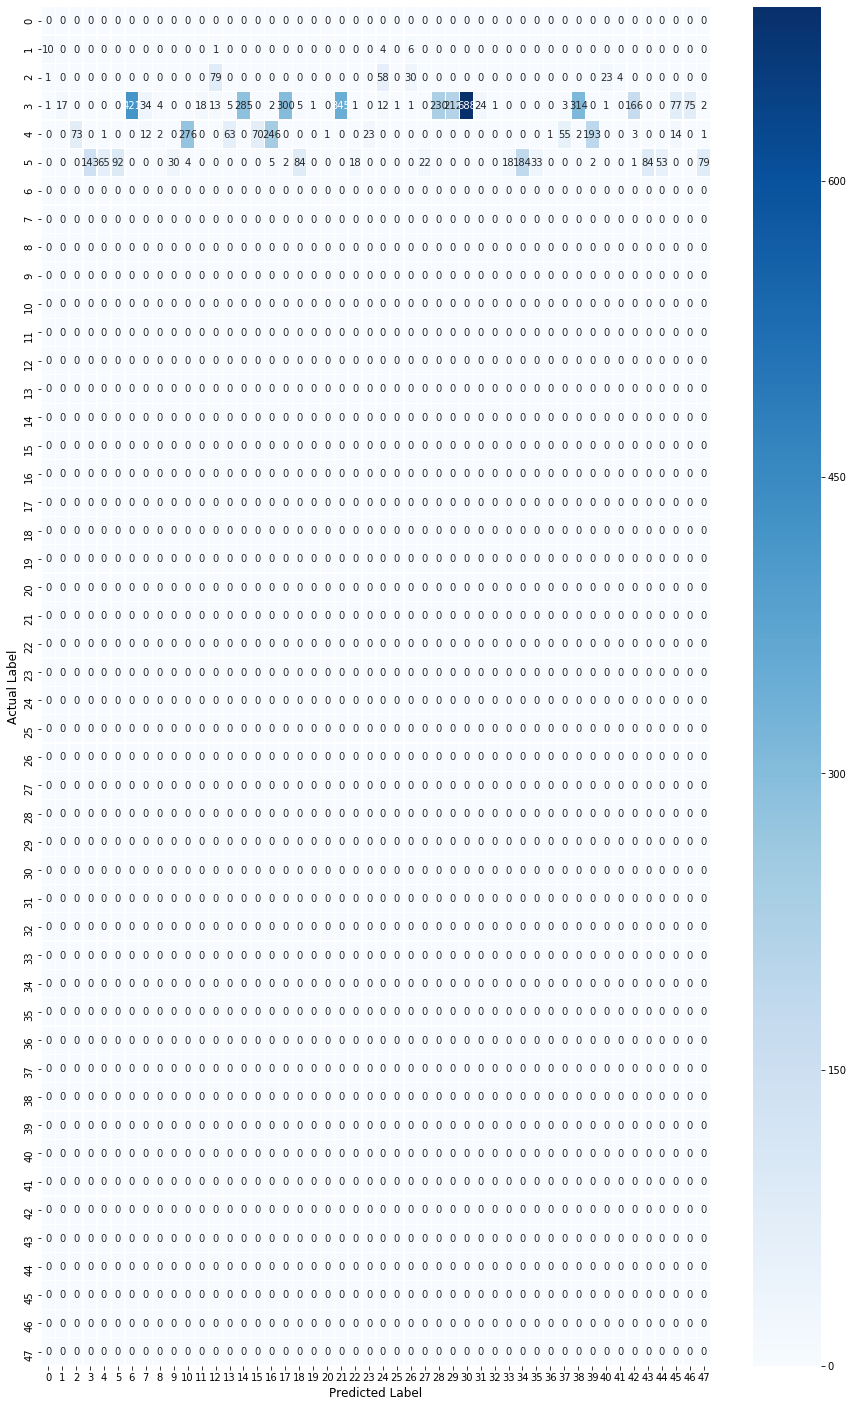

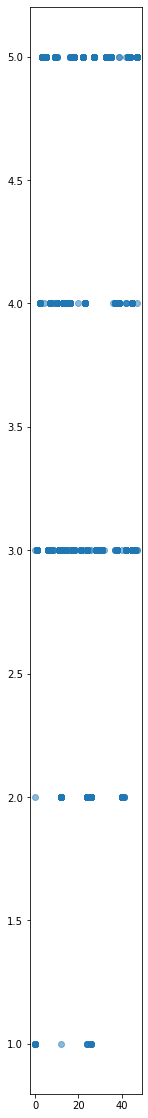

In [15]:

###### Plotting 

plt.figure(figsize=(6,6))
plt.scatter(data_to_use.iloc[:,4], data_to_use.iloc[:,7], c=y_pred_g, cmap='gist_rainbow', alpha = .4, edgecolors='#C5C9C7')
cbar = plt.colorbar()
plt.xlabel('PT(MgO)', fontsize=12)
plt.ylabel('PT(K2O)', fontsize=12)
#plt.title('Clustered Labels')

plt.figure(figsize=(6,6))
plt.scatter(data_to_use.iloc[:,13], data_to_use.iloc[:,14], c=y_pred_g, cmap='gist_rainbow', alpha = .4, edgecolors='#C5C9C7')
cbar = plt.colorbar()
plt.xlabel('PT(Ba)', fontsize=12)
plt.ylabel('PT(Rb)', fontsize=12)
#plt.title('Clustered Labels')
#plt.legend(labels=('0''1' '2'))


#from mpl_toolkits import mplot3d
#plt.figure()
#mplot3d.scatter3D(new_df.iloc[:,0], new_df.iloc[:,1], new_df.iloc[:,2], c=new_labels, cmap='tab20', alpha = .75)
#cbar = plt.colorbar()
#plt.xlabel('Ba')
#plt.ylabel('TiO2')
#plt.title('Original Labels')

#
## Creating 3D scatter figure
#fig = plt.figure(figsize = (7,7))
#ax = plt.axes(projection ="3d")
## Add x, y gridlines
#ax.grid(b = True, color ='grey',
#        linestyle ='-.', linewidth = 0.3,
#        alpha = 0.2)
## Creating color map
#my_cmap = plt.get_cmap('hsv')
# 
## Creating plot
#sctt = ax.scatter3D(new_df.iloc[:,0], new_df.iloc[:,1], new_df.iloc[:,2],
#                    alpha = 0.8,
#                    c = new_labels,
#                    cmap='rainbow',
#                    marker ='^')
# 
#
#ax.set_xlabel('Si', fontweight ='bold')
#ax.set_ylabel('Ti', fontweight ='bold')
#ax.set_zlabel('Al', fontweight ='bold')
##fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
# 
## show plot
#plt.show()
#
#
cm2 = metrics.confusion_matrix(labels_to_use,y_pred_g)
plt.figure(figsize=(15,25))
sns.heatmap(cm2, annot=True, fmt=".0f", linewidths=.25, square = False, cmap = 'Blues');
plt.ylabel('Actual Label', fontsize=12);
plt.xlabel('Predicted Label', fontsize=12);


#sns.boxplot(x=y_pred_g, y=labels)
#X, Y = np.meshgrid(np.linspace(-5, 5), np.linspace(-5,5))
#XX = np.array([X.ravel(), Y.ravel()]).T
#
#
#Z = y_pred_g.score_samples(new_df)
#Z = Z.reshape((50,50))
#plt.contour(X, Y, Z)
#plt.scatter(new_df.iloc[:,14], new_df.iloc[:,13])
#plt.show()

#plt.figure()
#plt.scatter(y_pred_g, labels)
#y_predz=pd.DataFrame(y_pred_g)
#
#from collections import Counter
#plt.figure(figsize=(5,5))
#weights = [i for i in Counter(y_pred_g).values() for j in range(i)]
plt.figure(figsize=(2,20))
plt.scatter(y_pred_g, labels_to_use, alpha=.5)
plt.show()
#df1=pd.DataFrame(y_pred_g)
#df2=pd.DataFrame(new_labels)
#df_predz=pd.DataFrame(pd.concat([df1,new_labels]))
#


In [18]:

#y_pred_G=pd.DataFrame(y_pred_g)

#print('Cluster Means:', y_pred_G.means_)

normed_means0 = y_pred_G.means_[0] / mean_im
normed_means1 = y_pred_G.means_[1] / mean_im
normed_means2 = y_pred_G.means_[2] / mean_im




# morb_means0 = y_pred_G.means_[0] / morb_data
# morb_means1 = y_pred_G.means_[1] / morb_data
# morb_means2 = y_pred_G.means_[2] / morb_data


# pm_means0 = y_pred_G.means_[0] / pm_data
# pm_means1 = y_pred_G.means_[1] / pm_data
# pm_means2 = y_pred_G.means_[2] / pm_data



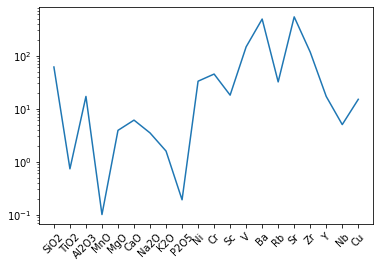

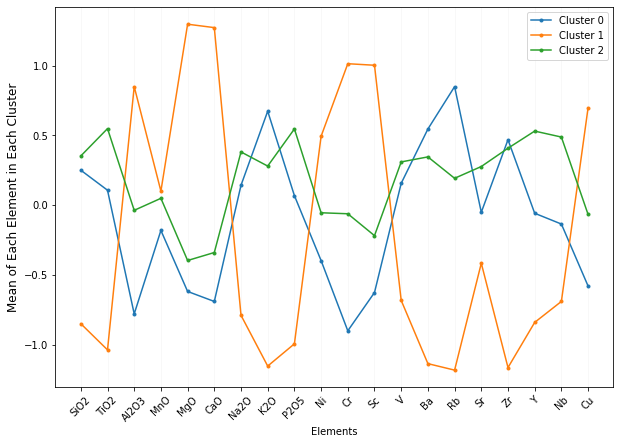

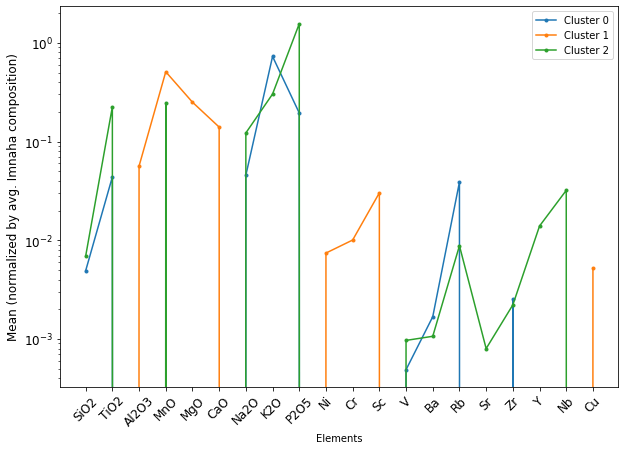

NameError: name 'morb_means0' is not defined

<Figure size 720x504 with 0 Axes>

In [19]:

plt.figure()
plt.plot(list(pm_data.columns.values), pd.DataFrame(pm_data.T))
plt.yscale('log')
plt.xticks(rotation = 45)
#plt.ylim(0,550)




plt.figure(figsize = (10,7))
plt.plot(list(df_gr.columns.values), y_pred_G.means_[0], label='Cluster 0', marker='.')
plt.plot(list(df_gr.columns.values), y_pred_G.means_[1], label='Cluster 1', marker='.')
plt.plot(list(df_gr.columns.values), y_pred_G.means_[2], label='Cluster 2', marker='.')
#plt.scatter(list(df_gr.columns.values), y_pred_G.means_[3], label='Cluster 4')
#plt.scatter(list(df_gr.columns.values), y_pred_G.means_[4], label='Cluster 5')
plt.xlabel('Elements')
plt.ylabel('Mean of Each Element in Each Cluster', fontsize=12)
plt.xticks(rotation = 45)
#plt.yscale('log')
plt.legend()
plt.grid(axis='x', color='0.97')
#plt.hlines(1, df_gr.columns.values[0], df_gr.columns.values[19], 'k', '--')
plt.show()




plt.figure(figsize = (10,7))
plt.plot(list(df_gr.columns.values), normed_means0, label='Cluster 0', marker='.')
plt.plot(list(df_gr.columns.values), normed_means1, label='Cluster 1', marker='.')
plt.plot(list(df_gr.columns.values), normed_means2, label='Cluster 2', marker='.')
#plt.plot(list(df_gr.columns.values), y_pred_G.means_[3], label='Cluster 4')
#plt.plot(list(df_gr.columns.values), y_pred_G.means_[4], label='Cluster 5')
plt.xlabel('Elements')
plt.ylabel('Mean (normalized by avg. Imnaha composition)', fontsize=12)
plt.xticks(rotation = 45, fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
#plt.hlines(1, df_gr.columns.values.min(), df_gr.columns.values.max())
plt.legend()
plt.show()







plt.figure(figsize = (10,7))
plt.plot(list(df_gr.columns.values), morb_means0.T, label='Cluster 0', marker='.')
plt.plot(list(df_gr.columns.values), morb_means1.T, label='Cluster 1', marker='.')
plt.plot(list(df_gr.columns.values), morb_means2.T, label='Cluster 2', marker='.')
#plt.plot(list(df_gr.columns.values), y_pred_G.means_[3], label='Cluster 4')
#plt.plot(list(df_gr.columns.values), y_pred_G.means_[4], label='Cluster 5')
plt.xlabel('Elements')
plt.ylabel('Mean (normalized by avg. MORB composition)', fontsize=12)
plt.xticks(rotation = 45, fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
#plt.hlines(1, df_gr.columns.values.min(), df_gr.columns.values.max())
plt.legend()
plt.show()





plt.figure(figsize = (10,7))
plt.plot(list(df_gr.columns.values), pm_means0.T, label='Cluster 0', marker='.')
plt.plot(list(df_gr.columns.values), pm_means1.T, label='Cluster 1', marker='.')
plt.plot(list(df_gr.columns.values), pm_means2.T, label='Cluster 2', marker='.')
#plt.plot(list(df_gr.columns.values), y_pred_G.means_[3], label='Cluster 4')
#plt.plot(list(df_gr.columns.values), y_pred_G.means_[4], label='Cluster 5')
plt.xlabel('Elements')
plt.ylabel('Mean (normalized by Petcovic Stage 5 composition)', fontsize=12)
plt.xticks(rotation = 45, fontsize=12)
plt.yticks(fontsize=12)
#plt.yscale('log')
#plt.hlines(1, df_gr.columns.values.min(), df_gr.columns.values.max())
plt.legend()
plt.show()



In [ ]:



########## Synthetic MCS Data

mcs_data= pd.read_csv('SynthAFC2_trimmed.csv', header=0)

features_PT2= PowerTransformer().fit_transform(mcs_data)
features_mcs =pd.DataFrame(features_PT2, columns=mcs_data.columns)



from matplotlib.patches import Ellipse

plt.figure()
#plt.plot(features_mcs.iloc[:,1], features_mcs.iloc[:,2], c='k', alpha = .4)
plt.scatter(new_df.iloc[:,1], new_df.iloc[:,2], c=y_pred_g, cmap='plasma', alpha = .4)
cbar = plt.colorbar()
plt.xlabel('Ti')
plt.ylabel('Al')
plt.title('Clustered Labels')






plt.figure()
plt.plot(features_mcs.iloc[:,0], features_mcs.iloc[:,2], c='k', alpha = .4)
plt.scatter(new_df.iloc[:,1], new_df.iloc[:,2], c=y_pred_g, cmap='plasma', alpha = .4)
#cbar = plt.colorbar()
plt.xlabel('Si')
plt.ylabel('Al')
plt.title('Clustered Labels')


# Creating 3D scatter figure
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection ="3d")
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
# Creating color map
my_cmap = plt.get_cmap('hsv')
 
# Creating plot
sctt2 = ax.scatter3D(features_mcs.iloc[:,0], features_mcs.iloc[:,1], features_mcs.iloc[:,2],
                    alpha = 0.8,
                    c = 'k',
                    cmap='plasma',
                    marker ='o')
 

ax.set_xlabel('SiO2', fontweight ='bold')
ax.set_ylabel('TiO2', fontweight ='bold')
ax.set_zlabel('Al2O3', fontweight ='bold')
#fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
 
# show plot
plt.show()

